In [6]:
%matplotlib inline
import numpy as np
import pandas as pd
import cv2

try:
    # Font로 자동으로 이미지 만들기
    import cairocffi as cairo
except:
    !pip install cairocffi
    
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib
from scipy import ndimage
from functools import partial

import re
import sys
sys.path.append("../")
from utils.dataset import OCRDataset
from models.generator import OCRGenerator, KOR2IDX, KOR_CHARS

## 한글 Matplotlib 출력 세팅

In [7]:
# 1. 나눔 폰트를 다운받기
!apt-get update -qq
!apt-get install fonts-nanum* -qq

import matplotlib.font_manager as fm
# 2. 나눔 폰트의 위치 가져오기 
system_font = fm.findSystemFonts() # 현재 시스템에 설치된 폰트
nanum_fonts = [font for font in system_font if "NanumBarunGothic.ttf" in font]
font_path = nanum_fonts[0] # 설정할 폰트의 경로

# 3. 나눔 폰트로 설정하기
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
plt.rc("font",family=font_name)

# 4. 폰트 재설정하기
fm._rebuild()

# 5. (optional) minus 기호 깨짐 방지
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False

/bin/sh: apt-get: command not found
/bin/sh: apt-get: command not found


## Data Exploration

In [8]:
# 단어 최소/최대 길이
min_words = 4
max_words = 8

# OCRDataset setting
OCRDataset = partial(OCRDataset,
                     font_size=24,
                     bg_noise=0.2,
                     affine_noise=(0.0,0.03),
                     color_noise=(0.3,0.6),
                     gray_scale=True)

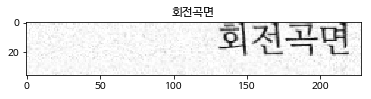

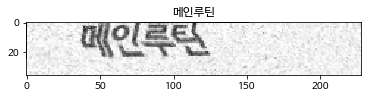

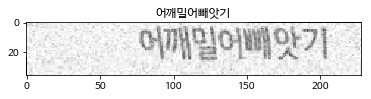

In [9]:
df = pd.read_csv("../datasets/wordslist.txt",names=['word'])
df = df.drop_duplicates()
df = df[df.word.str.match(r'^[가-힣]+$')]
df = df[
    df.word.map(
        lambda x: (len(x) >= min_words) 
        and (len(x) <= max_words))]
words = df.word.values
np.random.shuffle(words)

dataset = OCRDataset(words)
images, labels = dataset[0:3]

for image, label in zip(images, labels):
    plt.title(label)
    plt.imshow(image[:,:,0],cmap='gray')
    plt.show()

In [10]:
# 단어 군을 기준으로 나누기 
# validation words는 5%만 둚

valid_words = words[:len(words)*5//100]
train_words = words[len(words)*5//100:]

valid_set = OCRDataset(valid_words)
train_set = OCRDataset(train_words)

train_gen = OCRGenerator(train_set, batch_size=16, eos_token=True)
valid_gen = OCRGenerator(valid_set, batch_size=16, eos_token=True)

## Modeling

In [11]:
from models.keras_crnn import ConvFeatureExtractor, Map2Sequence 
from models.keras_crnn import BLSTMEncoder, CTCDecoder, ctc_loss

import tensorflow as tf
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense

In [ ]:
height = 36
num_classes = len(KOR_CHARS)
K.clear_session()

# For Gray Scale Image & Dynamic width
inputs = Input(shape=(height, None, 1))

# Preprocessing : (0,255.) -> (-1,1.)
preprocess = (inputs - 127.5) / 255.

# (batch size, height, width, channels) -> (batch size, width, height, channels)
transposed = K.permute_dimensions(preprocess, (0, 2, 1, 3))

# CRNN Model
conv_maps = ConvFeatureExtractor(name='feature_extractor')(transposed)
feature_seqs = Map2Sequence(name='map_to_sequence')(conv_maps)
lstm_seqs = BLSTMEncoder()(feature_seqs)
# 우리의 출력 형태는 class 수에 Blank Label을 하나 더해 #classes + 1 만큼을 출력
output_seqs = Dense(num_classes+1, activation='softmax', name='output_seqs')(lstm_seqs)

# 모델 구성하기
# (1) 학습 모델 구성하기
y_true =  tf.placeholder(shape=(None,None),dtype=tf.int32)
trainer = Model(inputs, output_seqs, name='trainer')
trainer.compile('adam',
                loss={"output_seqs":ctc_loss},
                target_tensors=[y_true])

# Caution :
# CTC Loss의 경우 y_pred와 y_true의 형태가 다릅니다.
# Keras는 y_pred과 y_true의 shape가 동일하다고 가정하기 때문에, 다른 경우
# compile 시 target_tensor에 직접 y_true의 형태를 지정해주어야 합니다.

# (2) 예측 모델 구성하기
predictions = CTCDecoder(beam_width=100)(output_seqs)
predictor = Model(inputs, predictions, name='predictor')

In [ ]:
trainer.fit_generator(train_gen,
                      epochs=10,
                      validation_data=valid_gen)

---

# [TODO] Attention GRU Modeling

---

### Reference : 

1. [Neural Machine Translation By Jointly Learning to Align and Translate](https://arxiv.org/pdf/1409.0473.pdf)
2. [Bahdanau Attention 개념 정리](https://hcnoh.github.io/2018-12-11-bahdanau-attention)

### GRU의 기본 공식
<br>
$
\hat y_t = softmax(W_y \cdot s_t + b_y) \\
s_t = z_t \odot s_{t-1} + (1-z_t) \odot \bar s_t \\
z_t = \sigma(W_z y_{t-1} + U_z s_{t-1} + b_z) \\
r_t = \sigma(W_r y_{t-1} + U_r s_{t-1} + b_r) \\
\bar s_t = tanh(W_s y_{t-1} + U_s(r_t \odot s_{t-1}) + b_s) \\
$

Attention 메커니즘을 활용하여 위의 연산들을 재정의하면 아래와 같이 정리할 수 있다. <br>
<br>
$
\hat y_t = softmax(W_y \cdot s_t + b_y) \\
s_t = z_t \odot s_{t-1} + (1-z_t) \odot \bar s_t \\
z_t = \sigma(W_z y_{t-1} + U_z s_{t-1} + C_z c_t + b_z) \\
r_t = \sigma(W_r y_{t-1} + U_r s_{t-1} + C_r c_t + b_r) \\
\bar s_t = tanh(W_s y_{t-1} + U_s(r_t \odot s_{t-1}) + C_s c_t + b_s) \\
$

GRU 모델 및 기본 RNN 모델에서의 Context Vector의 활용을 살펴보면 다음의 특징을 파악할 수 있습니다. Context Vector $c_t$는 RNN의 입력으로 사용되는 $y_{t-1}$ 과 함께 등장하며 함께 임베딩 공간에 뿌려져서 더해지는 방식으로 활용됩니다. 즉, 간단하게 정리하자면 $Wy_{t-1}$ 대신 $W y_{t-1} + C c_t$가 된다는 것이다. 이건 RNN 입력을 y_{t-1} 단독으로 사용하는 것이 아니라 Context Vector C_t와 Concatenation하여 사용하는 것과 같은 의미입니다. 이걸 수식으로 정리하면 다음과 같습니다. 




In [ ]:
from tensorflow.keras.layers import GRU, Embedding
from tensorflow.keras.layers import Layer, GRUCell, LSTMCell, RNN

In [ ]:
class AttentionCell(Layer):
    """
    Robust Scene Text Recognition with Automatic Rectification에서 나오는 
    <Attend> Network에 대한 Module Class
    
    Reference : 
    
    BLSTM Encoder Sequence에서 우리가 원하는 Text Sequence으로 바꾸기 위해, 
    BLSTM 부분에서 어떤 것들이 필요한 것인지를 파악
    """
    def __init__(self, n_units, **kwargs):
        self.state_size = n_units
        self.input_proj_layer = Dense(n_units, use_bias=False, 
                                      name='input_project')
        self.state_proj_layer = Dense(n_units,
                                      name='state_project')
        self.score_layer = Dense(1, use_bias=False,
                                 name='score')
        self.gru_layer = GRUCell(n_units)        
        super().__init__(**kwargs)
        
    def call(self, inputs, states):
        # (batch size, time step, hidden size) -> (batch size, time step, hidden size)
        h_proj = self.input_proj_layer(inputs)
        # (batch size, hidden size) -> (batch size, 1, hidden size)
        s_proj = self.state_proj_layer(states[0])
        s_proj = s_proj[:,None,:]
        
        # (batch size, time step, hidden size) 
        # -> (batch size, time step, 1) -> (batch size, time step)
        score = self.score_layer(K.tanh(h_proj+s_proj))
        score = score[:,:,0]
        
        alpha = K.softmax(score)[:,:,None]
        context = K.sum(inputs*alpha, axis=1)
                
        alpha = tf.identity(alpha, name='alpha')        
        context = tf.identity(context, name='context')
        print("Context : ", context.shape)
        print("State[0]   : ", self.gru_layer(context, states)[0].shape)
        print("State[1]   : ", self.gru_layer(context, states)[1])
        return self.gru_layer(context, states)
    

In [ ]:
K.clear_session()

# For Gray Scale Image & Dynamic width
inputs = Input(shape=(height, None, 1))
labels = Input(shape=(None,))

x = Embedding(num_classes+1,256)
y = x(labels)

# (batch size, height, width, channels) -> (batch size, width, height, channels)
transposed = K.permute_dimensions(inputs, (0, 2, 1, 3))

# CRNN Model
conv_maps = ConvFeatureExtractor(name='feature_extractor')(transposed)
feature_seqs = Map2Sequence(name='map_to_sequence')(conv_maps)
blstm_seqs = BLSTMEncoder(n_units=256,name='blstm_encoder')(feature_seqs)
# attend_seqs = RNN(AttentionCell(n_units=256*2),
#                   return_sequences=True, 
#                   name='GRU_Attention')(blstm_seqs)


In [ ]:
Attention?

In [ ]:
from tensorflow.keras.layers import Attention, AdditiveAttention

In [ ]:
AdditiveAttention?

In [ ]:
blstm_seqs

In [ ]:
attend_states

In [ ]:
output_seqs = Dense(num_classes+1, activation='softmax')(attend_seqs)

In [ ]:
output_seqs